In [2]:
import pandas as pd
teams = pd.read_csv("teams5sb.csv", index_col=[0,1])

teams.columns=[x.lower() for x in teams.columns]

In [11]:
us = pd.read_csv("usPPDA.csv", index_col=[0,1])
us=us[['PPDA']].rename(columns={'PPDA':'ppda'})
teams=teams.join(us)



In [82]:

# bramkarz-obrona-pomoc-atak-trener
# (PSxG-GA)/SoT; opp_xG; xG; Gls/xG
# ; SoTA; SCA; ;
bramkarz=['psxg','ga','sot']
obrona=['opp_xg','sota']
pomoc=['xg','sca']
atak=['gls','xg']
trener=['opp_xg'] #'opp_xg' vs AVGopp_xg

taktyka =['dist','cpa','1/3']# Dist(shot) C1/3 CPA
offence=['def pen','def 3rd','mid 3rd','att 3rd','att pen','touches'] #Touches[Def3rd Mid3rd Att3rd]/Touches
intensity=['touches']
wide=['sw','crs','att','opp_ti'] #/Poss Sw Crs Take-Ons[Att]'opp_ti'
speed=['poss','prgdist'] #PrgP/Poss poss/prgdist
stalefragmenty =['dead','fk','ti','ck', 'gca passdead'] #/Poss Dead,FK,TI,CK GCA pass dead
press=['sca def','tackles def 3rd', 'tackles mid 3rd', 'tackles att 3rd','tackles tkl','fls','won','opp_rec','opp_total cmp','opp_total att','recov']
# SCA_Def,Tackles[Def3rd Mid3rd Att3rd], *oppRec, Fls AWon 
where=['tackles def 3rd','tackles mid 3rd','tackles att 3rd','def 3rd','mid 3rd','att 3rd','att pen','def pen']
error=['challenges lost','tackles tklw','tackles tkl','err','mis','dis','crdy','og','lost']
# ChallengesLost TklW/TklAtt Err Mis Dis CrdY OG Alost
succ=['int','tackles tklw','succ','challenges tkl','blocks','opp_total att','recov'] #Int TklW ChaTkl Take-Ons[Att] blocks 'opp_total att'

subset=bramkarz+obrona+pomoc+atak+trener+taktyka+offence+intensity+wide+speed+stalefragmenty+press+error+where
subset=list(set(subset))
len(subset)
df=teams[subset+['ppda']]
def norm(df):
    return (df-df.min())/(df.max()-df.min())
# norm(sel['xG']).sort_values()
# sel.rank(pct = True)
dfn=norm(df)
dfnr=dfn.reset_index(drop=True)

In [84]:
possible=['tackles att 3rd','tackles mid 3rd','fls','opp_total att','opp_total cmp','opp_rec',
'def 3rd','att 3rd','mid 3rd', 'touches',
'sca def', 'recov'
]
dfnr=dfnr[possible]

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
import numpy as np


In [38]:
# Create train/test split for initial holdout
from sklearn.model_selection import train_test_split

def reg_prep(dfnr,to_pred_cols_lst,test_size=0.3):
    # Create arrays for features and target variable
    df_to_pred= dfnr[to_pred_cols_lst]
    y = df_to_pred.values
    df_wo_y = dfnr.drop(to_pred_cols_lst,axis='columns')
    X = df_wo_y.values

    y_labels=df_to_pred.columns
    x_labels=df_wo_y.columns

    # Create training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=42)
    return X_train, X_test, y_train, y_test,x_labels,y_labels

def categorical_prep(df1,col):
# if CATEGORICAL data
# Create dummy variables: 
    df2=df1.join(pd.get_dummies(df1[col]))
    df2.drop([col],axis='columns', inplace=True)
    return df2

def categorical_code(pds):
    return pds.astype("category").cat.codes

def importants(labels,coefs):
    df1=pd.DataFrame()
    df1['a']=cols
    df1['b']=coefs
    df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0.02]
    return(df1)

X_train, X_test, y_train, y_test,cols,_ = reg_prep(dfnr,['ppda'])

[[ 9.76294928e-02  2.12496165e+00 -1.35822227e-01 -5.98292146e+00
   8.05568885e+00  1.99266916e-02 -3.56354555e-01 -1.28148813e-01
   1.77974112e-03  2.47547477e-02  2.58883736e-01 -2.14442072e-01
  -1.49117978e-01 -3.94882731e-02 -2.49858349e-02  1.74588966e-03
  -4.70364525e-02  6.10276479e-02 -8.79473002e+00  1.78097573e-02
  -3.29430559e-02  4.58283389e-02  3.20830565e-02  3.31416483e+00
   8.93946058e-03 -8.99614965e-02 -1.60876466e+00  7.96490097e-02
  -2.00939545e-01  6.43226098e-02 -8.22912525e-02 -1.62532671e-01
  -8.83676163e-02  5.88438072e-02 -1.74566530e-01 -1.42861590e-01
   1.81367530e-02 -3.38280578e-03  1.71291637e-01  6.27901995e-02
   6.20154747e-02 -1.49711729e-01 -9.23741268e-02  5.69668656e+00
  -6.89152491e-04  4.53379069e-02]]


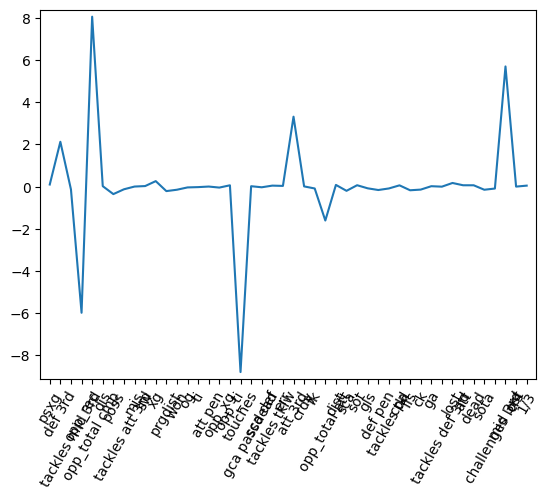

[0.67012661 0.12486096 0.40629664 0.91121081 0.60813429]
0.5441258608684201
R^2 on holdout
0.8834861484251624


In [40]:
# LinearRegression

# Import necessary modules
from sklearn.linear_model import LinearRegression

# Create the regressor: reg_all
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg.predict(X_test)

# Compute and print the coefficients
print(reg.coef_)

# Plot the coefficients
plt.plot(range(len(cols)), reg.coef_[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)
print(np.mean(cv_scores))


# Compute and print R^2 on holdout
print('R^2 on holdout')
print(reg.score(X_test, y_test))

In [78]:

importants(cols,reg.coef_[0])
# 'def 3rd'	2.124962
# 'att 3rd'	3.314165
# 'mid 3rd'	5.696687
# 'opp_total' cmp	8.055689

# 'touches'	-8.794730
# 'opp_rec'	-5.982921
# 'opp_total att'	-1.608765


C:\Users\krawc\AppData\Local\Temp\ipykernel_2696\1055027511.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0.02]


,a,b
18,touches,-8.794730
4,opp_total cmp,8.055689
3,opp_rec,-5.982921
43,mid 3rd,5.696687
23,att 3rd,3.314165
1,def 3rd,2.124962
26,opp_total att,-1.608765
6,poss,-0.356355
10,xg,0.258884
11,prgdist,-0.214442


[ 0.         -0.         -0.03073329  0.5949841   0.         -0.
 -0.         -0.01960422 -0.         -0.         -0.         -0.
 -0.          0.         -0.         -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.00480102 -0.
  0.         -0.         -0.          0.         -0.          0.
 -0.         -0.         -0.         -0.        ]


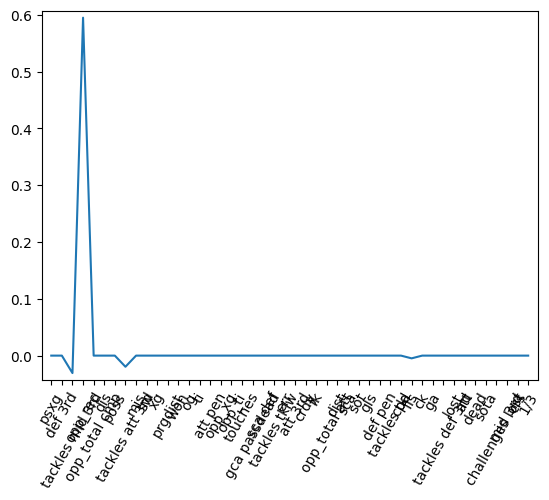

[0.74502941 0.78392004 0.67741285 0.69598394 0.88334823]
0.7571388958348615
R^2 on holdout
0.8156299045780283


In [45]:
#LASSO

# Import Lasso
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# # Instantiate a lasso regressor: lasso
# lasso = Lasso(alpha=0.3, normalize=True)

# # Fit the regressor to the data
# lasso.fit(X_train,y_train)


# Setup the pipeline steps: steps
steps = [
        # ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.01))
        ]
pipeline = Pipeline(steps)
lasso = pipeline.fit(X_train, y_train)
lasso_coef = pipeline.named_steps['lasso'].coef_
# Compute and print the coefficients
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(cols)), lasso_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: 
lasso_cv = cross_val_score(lasso, X_train, y_train, cv=5)

# Print the cross-validated scores
print(lasso_cv)
print(np.mean(lasso_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(lasso.score(X_test, y_test))

[[ 0.03193299  0.00460212 -0.10337107  0.18933199  0.18780869  0.01012128
  -0.08027689 -0.12048887 -0.02450666  0.01473889 -0.00637037  0.01589558
  -0.05555172 -0.00847314 -0.02608747 -0.03011346  0.01454079 -0.01648912
  -0.02667648  0.00934855 -0.02210776 -0.01356565  0.00887399 -0.05001168
  -0.03557692 -0.05536225  0.1588627   0.03473103 -0.01888462 -0.02115376
   0.01649104 -0.03874878 -0.04063976  0.02478021 -0.12953063 -0.05015105
   0.00826009  0.05350303 -0.00437201  0.06603434 -0.01392745 -0.05428376
  -0.09982996 -0.01277867 -0.04031917  0.01364316]]


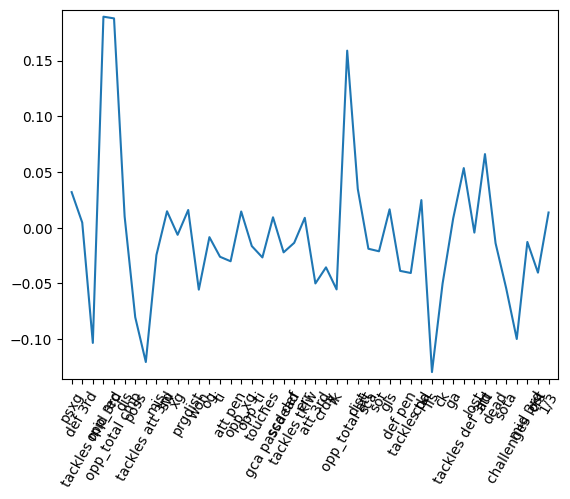

[0.91741292 0.81842089 0.91601772 0.89456812 0.96457424]
0.9021987788190712
R^2 on holdout
0.887238346957536
Test set RMSE: 0.065


In [52]:
# RIDGE

# Import necessary modules
from sklearn.linear_model import Ridge

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=0.8))]
pipeline = Pipeline(steps)
ridge = pipeline.fit(X_train, y_train)
ridge_coef = pipeline.named_steps['ridge'].coef_

# Compute and print the coefficients
print(ridge_coef)

# Plot the coefficients
plt.plot(range(len(cols)), ridge_coef[0])
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
ridge_cv = cross_val_score(ridge, X_train, y_train, cv=5)

# Print the cross-validated scores
print(ridge_cv)
print(np.mean(ridge_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(ridge.score(X_test, y_test))

y_pred=ridge.predict(X_test)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Print rmse_test
print('Test set RMSE: {:.3f}'.format(rmse_test))

[ 0.          0.         -0.06682194  0.30876683  0.30072834 -0.
 -0.         -0.08063417 -0.         -0.         -0.         -0.
 -0.          0.         -0.01410136 -0.          0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.00303551  0.         -0.         -0.
 -0.          0.         -0.         -0.         -0.05209872 -0.
  0.          0.         -0.          0.         -0.          0.
 -0.03900931 -0.         -0.         -0.        ]


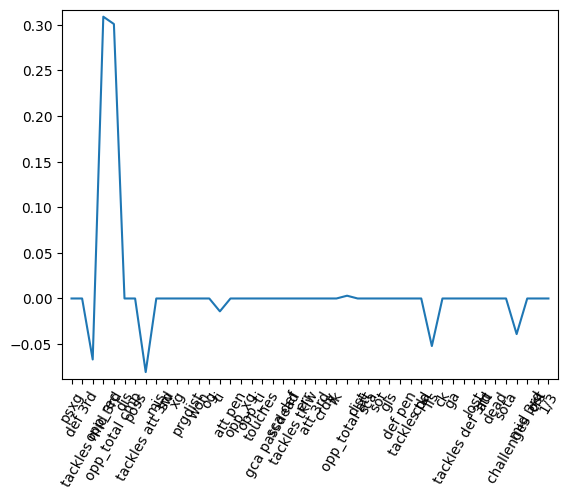

[0.83278354 0.83872466 0.82884429 0.79155801 0.92944933]
0.844271967844794
R^2 on holdout
0.864603415109393


In [53]:
#elastic net

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Setup the pipeline steps: steps
steps = [
    # ('scaler', StandardScaler()),
        ('elastic_net', ElasticNet(l1_ratio=0.6, alpha=0.01))]
pipeline = Pipeline(steps)
elastic_net = pipeline.fit(X_train, y_train)
elastic_net_coef = pipeline.named_steps['elastic_net'].coef_

# Compute and print the coefficients
print(elastic_net_coef)

# Plot the coefficients
plt.plot(range(len(cols)), elastic_net_coef)
plt.xticks(range(len(cols)), cols, rotation=60)
plt.margins(0.02)
plt.show()

# Perform 5-fold cross-validation: ridge_cv
elastic_net_cv = cross_val_score(elastic_net, X_train, y_train, cv=5)

# Print the cross-validated scores
print(elastic_net_cv)
print(np.mean(elastic_net_cv))

# Compute and print R^2 on holdout
print('R^2 on holdout')
print(elastic_net.score(X_test, y_test))



In [74]:

importants(cols,elastic_net_coef)
# 'tackles att 3rd'	-0.080634
# 'tackles mid 3rd	'-0.066822
# 'fls'	-0.052099
# 'opp_total cmp'	0.300728
# 'opp_rec'	0.308767
# 'tackles att 3rd','tackles mid 3rd','fls','opp_total cmp','opp_rec'

C:\Users\krawc\AppData\Local\Temp\ipykernel_2696\3271778965.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1=df1.sort_values('b',key=lambda x:-abs(x))[df1.b.abs()>0]


,a,b
3,opp_rec,0.308767
4,opp_total cmp,0.300728
7,tackles att 3rd,-0.080634
2,tackles mid 3rd,-0.066822
34,fls,-0.052099
42,challenges lost,-0.039009
14,ti,-0.014101
26,opp_total att,0.003036


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE

In [65]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=2, min_samples_leaf=0.3, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_pred, y_test)

# Compute rmse_dt
rmse_dt = mse_dt**(1/2)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(rmse_dt))

Test set RMSE of dt: 0.16


In [66]:
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))
# if CV RMSE is > Tree test set RMSE - means overfitting -> model too compilcated -> reduce parameters

CV RMSE: 0.13


In [67]:
# compare linear error vs tree error

# Predict test set labels 
y_pred_lr = reg.predict(X_test)

# Compute mse_lr
mse_lr = MSE(y_test, y_pred_lr)

# Compute rmse_lr
rmse_lr = mse_lr**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_lr))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 0.07
Regression Tree test set RMSE: 0.16


In [68]:
# Random Forests
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)
                           
# Fit rf to the training set   
y_train_1d= np.ravel(y_train)        
rf.fit(X_train, y_train_1d)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 0.10


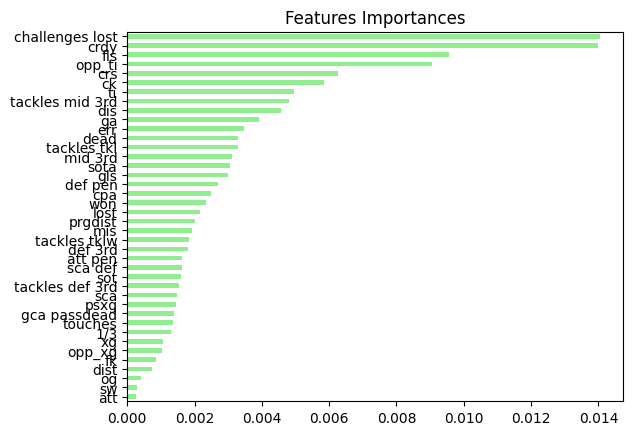

In [69]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_, index= cols)

# Sort importances
importances_sorted = importances.sort_values()[:40]

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [70]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=3,n_estimators=200,random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = gb.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 0.080


In [71]:
#Stochastic Gradient Boosting (SGB)

# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate sgbr
sgbr = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.8,
                                 max_features=0.4,
                                 n_estimators=200,                                
                                 random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train_1d)

# Predict test set labels
y_pred = sgbr.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test))

Test set RMSE of sgbr: 0.087
